HSE, Applied Time Series Forecasitng , Winter 2022-23 

<font color="blue"> Lesson #7: Time Series Forecasting with ML </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - demand forecasting, lagged features, time series CV

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

# Demand Time Series

In [400]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityWAPE, qualityRMSE
import warnings, pylab

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

In [401]:
# загружаем данные
ts_retail = pd.read_csv('train_kaggle/train_kaggle.csv', parse_dates=['Date'])
ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], dayfirst = True)
ts_retail.set_index(['Date'], inplace=True)
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22,163.78,NaN
2015-02-01,1,1,NaN,41,163.78,NaN
2015-03-01,1,1,NaN,35,163.78,NaN
2015-04-01,1,1,NaN,72,163.78,NaN
2015-05-01,1,1,NaN,25,163.78,NaN


In [402]:
ts_retail.tail()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2016-05-18,106,2,NaN,9,138.5,NaN
2016-05-19,106,2,NaN,3,138.5,NaN
2016-05-20,106,2,NaN,13,138.5,NaN
2016-05-21,106,2,NaN,3,138.5,NaN
2016-05-22,106,2,NaN,0,138.5,NaN


In [403]:
skus = ts_retail['SKU_id'].unique()
print(sorted(skus))

stores = ts_retail['Store_id'].unique()
print(sorted(skus))

[1, 2]
[1, 2]


In [404]:
ts_retail_test = pd.read_csv('test_kaggle.csv', parse_dates=['Date'])
ts_retail_test['Date'] = pd.to_datetime(ts_retail_test['Date'], dayfirst = True)
ts_retail_test.set_index(['Date'], inplace=True)

skus = ts_retail_test['SKU_id'].unique()
print(sorted(skus))

stores = ts_retail_test['Store_id'].unique()
print(sorted(skus))

[1, 2]
[1, 2]


In [405]:
ts_retail_test = pd.read_csv('test_kaggle.csv', parse_dates=['Date'])
ts_retail_test['Date'] = pd.to_datetime(ts_retail_test['Date'], dayfirst = True)
ts_retail_test.set_index(['Date'], inplace=True)

ts_retail_test.tail()

,id,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,,
2016-06-15,5965,110,2,NaN,NaN,133.06,NaN
2016-06-16,5966,110,2,NaN,NaN,133.06,NaN
2016-06-17,5967,110,2,NaN,NaN,133.06,NaN
2016-06-18,5968,110,2,NaN,NaN,133.06,NaN
2016-06-19,5969,110,2,NaN,NaN,133.06,NaN


In [406]:
test_start_dt = '05-22-2016'
test_end_dt = '06-19-2016'

ts_retail = ts_retail.append(ts_retail_test)
ts_retail = ts_retail.loc[:test_end_dt]
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,id
Date,,,,,,,
2015-01-01,1,1,NaN,22.0,163.78,NaN,NaN
2015-02-01,1,1,NaN,41.0,163.78,NaN,NaN
2015-03-01,1,1,NaN,35.0,163.78,NaN,NaN
2015-04-01,1,1,NaN,72.0,163.78,NaN,NaN
2015-05-01,1,1,NaN,25.0,163.78,NaN,NaN


In [407]:
ts_retail.tail()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,id
Date,,,,,,,
2016-06-15,110,2,NaN,NaN,133.06,NaN,5965.0
2016-06-16,110,2,NaN,NaN,133.06,NaN,5966.0
2016-06-17,110,2,NaN,NaN,133.06,NaN,5967.0
2016-06-18,110,2,NaN,NaN,133.06,NaN,5968.0
2016-06-19,110,2,NaN,NaN,133.06,NaN,5969.0


At this point we have attached the test time series to train. We will split them later by start date "2016-05-22." Let's keep them together for now to optimize data processing.

<AxesSubplot: xlabel='Date'>

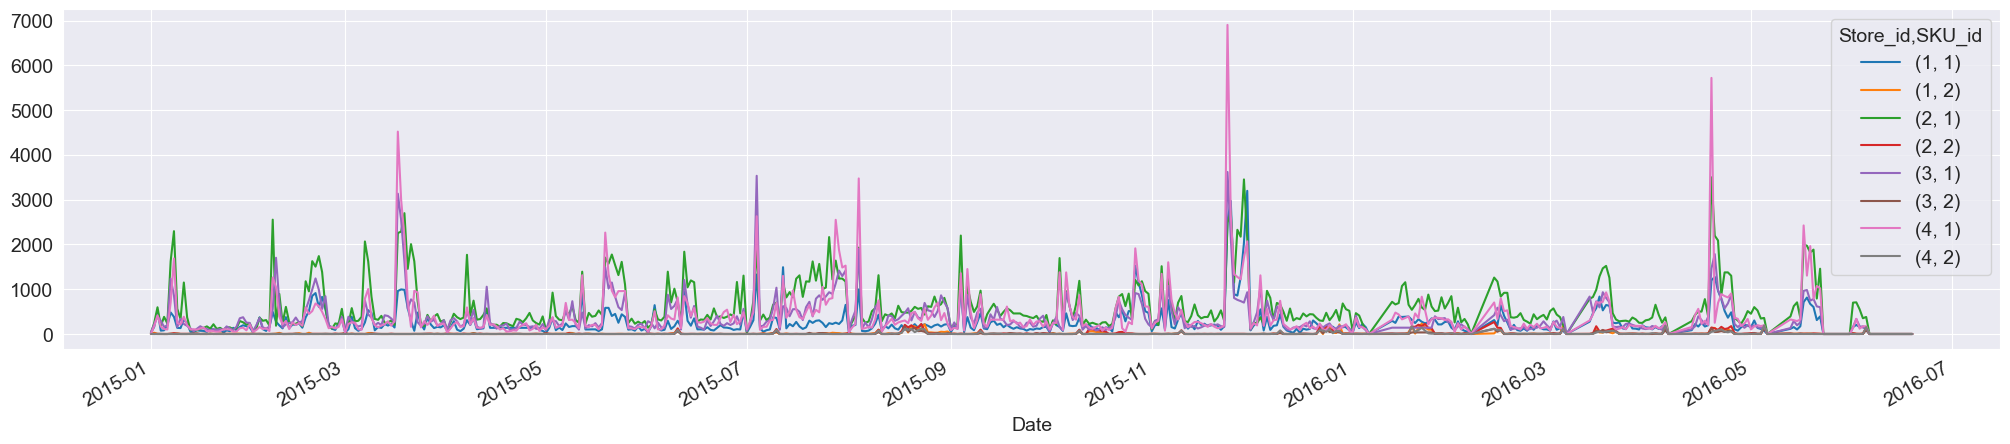

In [408]:
# Draw some time series
def plot_some_ts(ts_df, groupby_columns, time_column, target_column, ts_num = 10, aggregation_method = 'sum'):
  pivot_ts = ts_df.groupby(groupby_columns + [time_column]).agg(aggregation_method).\
     unstack(groupby_columns)[target_column]
  fig = pivot_ts[pivot_ts.columns[:ts_num]].plot()
  return fig


plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Demand', ts_num = 8)

<AxesSubplot: xlabel='Date'>

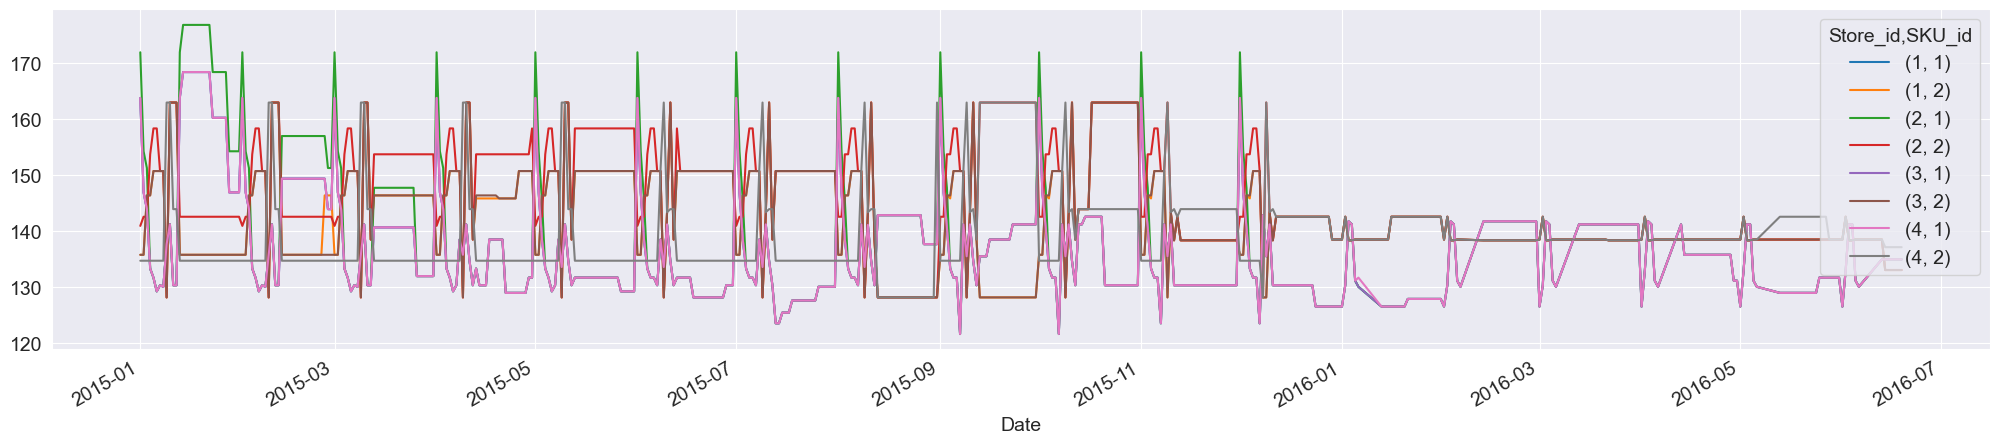

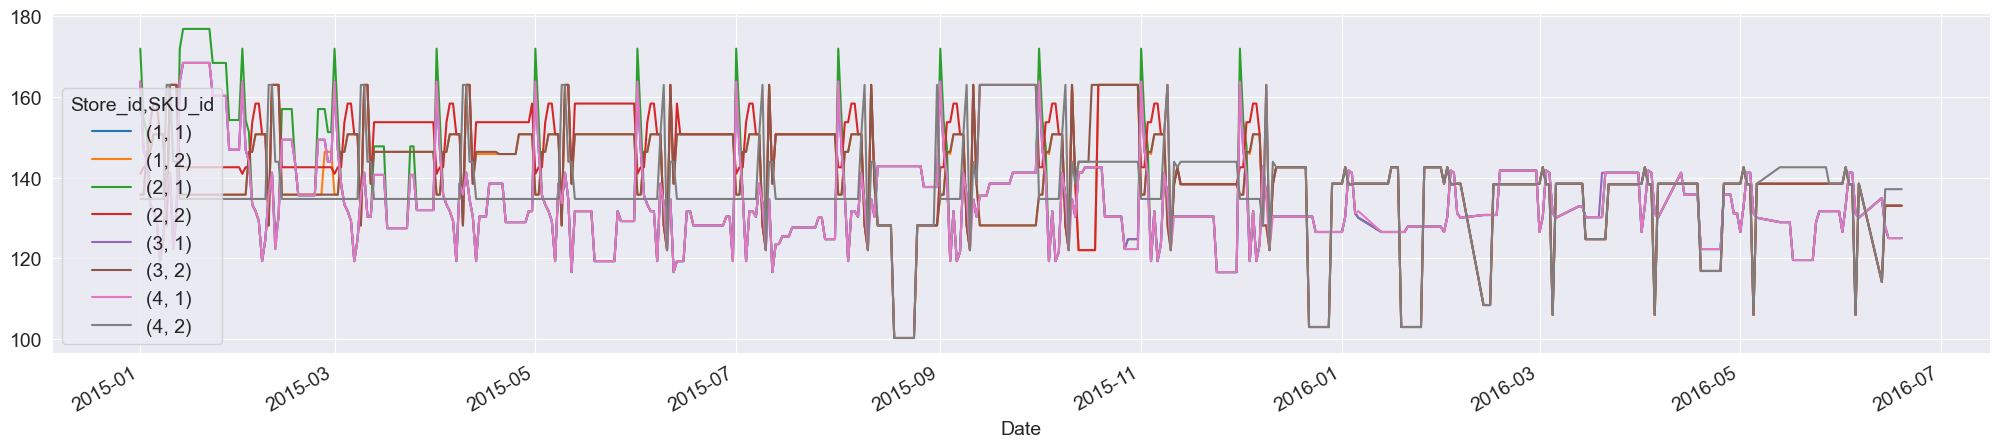

In [409]:
# Fill missings  (note: step is domain specific)
ts_retail['Promo'] = ts_retail['Promo'].fillna(0)
ts_retail.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
ts_retail['Regular_Price'] = ts_retail['Regular_Price'].ffill().bfill()
ts_retail.reset_index().set_index(['Date'], inplace=True)

plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Regular_Price', ts_num = 8)

# Add actual price (promo price when promo occurred or regular price otherwise)
ts_retail['Actual_Price'] = ts_retail.Promo_Price.combine_first(ts_retail.Regular_Price)
plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Actual_Price', ts_num = 8)

In [410]:
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,id,Actual_Price
Date,,,,,,,,
2015-01-01,1,1,0.0,22.0,163.78,NaN,NaN,163.78
2015-02-01,1,1,0.0,41.0,163.78,NaN,NaN,163.78
2015-03-01,1,1,0.0,35.0,163.78,NaN,NaN,163.78
2015-04-01,1,1,0.0,72.0,163.78,NaN,NaN,163.78
2015-05-01,1,1,0.0,25.0,163.78,NaN,NaN,163.78


<AxesSubplot: xlabel='Date'>

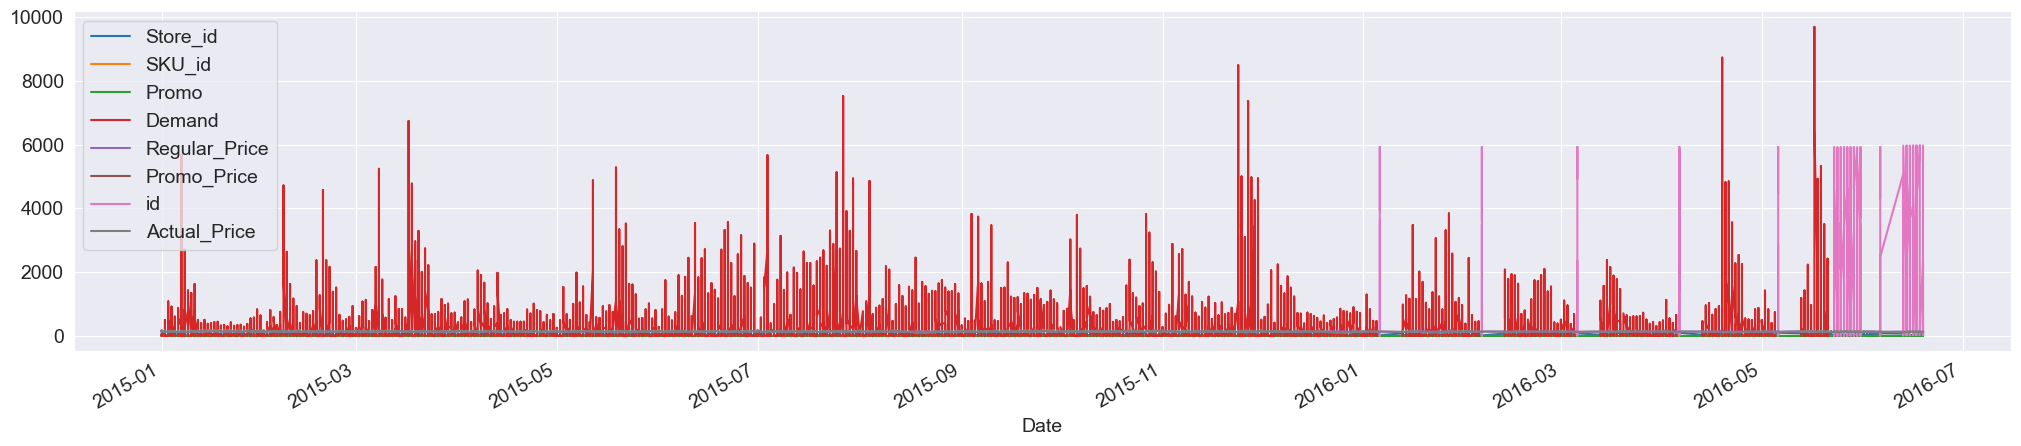

<Figure size 2500x500 with 0 Axes>

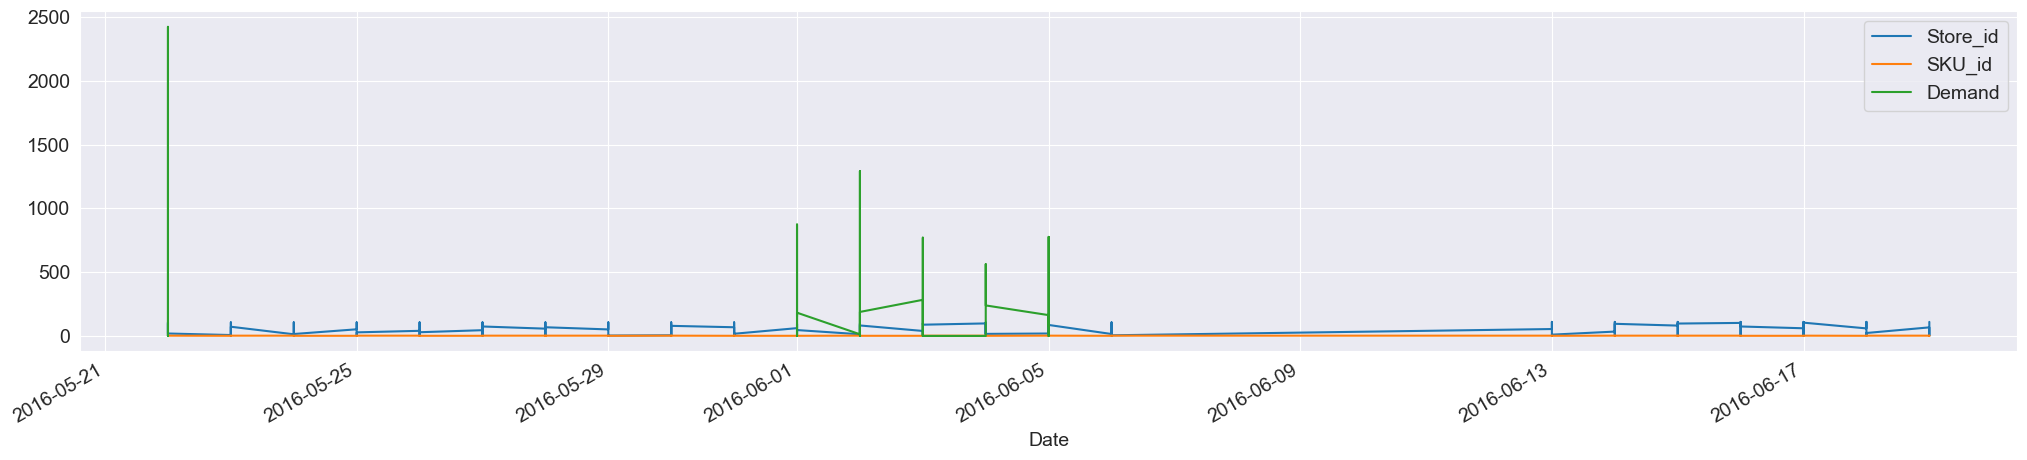

In [411]:
# prepare test/train datasets
train = ts_retail.copy(deep=True)
train.loc[test_start_dt:, 'Demand'] = np.NaN
train.plot()
test_y = ts_retail.loc[test_start_dt:, ['Store_id', 'SKU_id', 'Demand']]

plt.figure()
test_y.plot()

<AxesSubplot: xlabel='Date'>

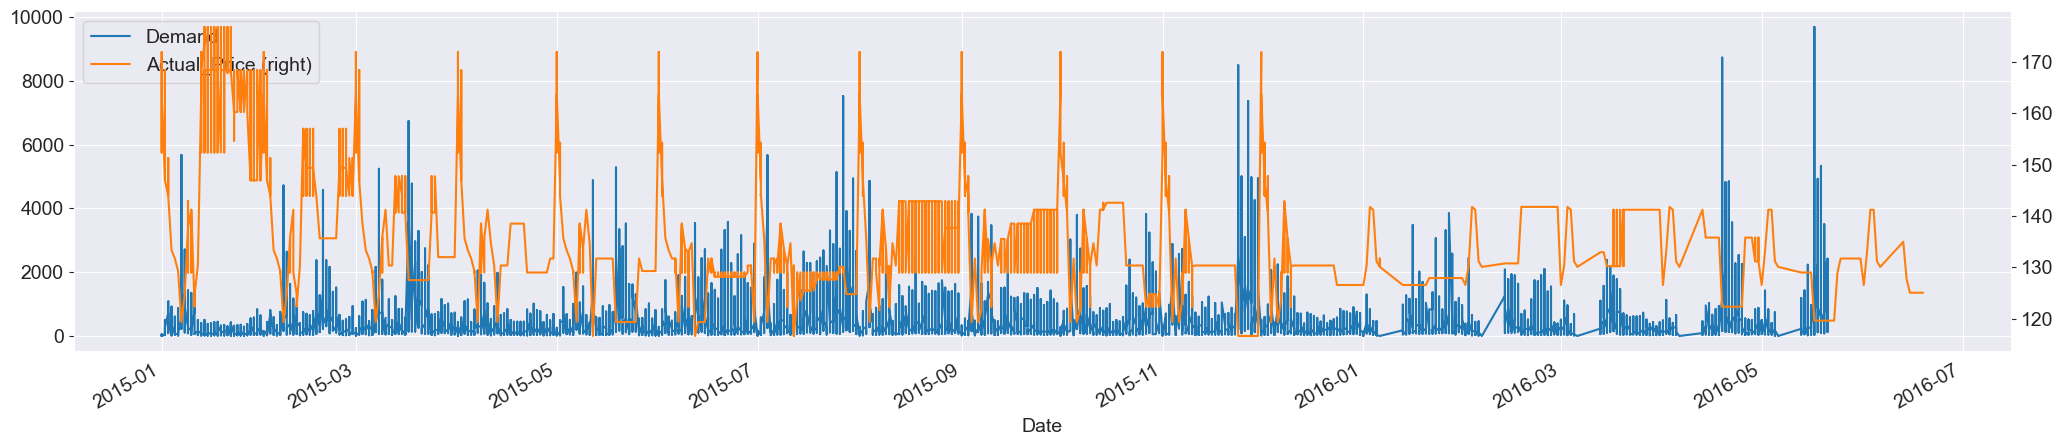

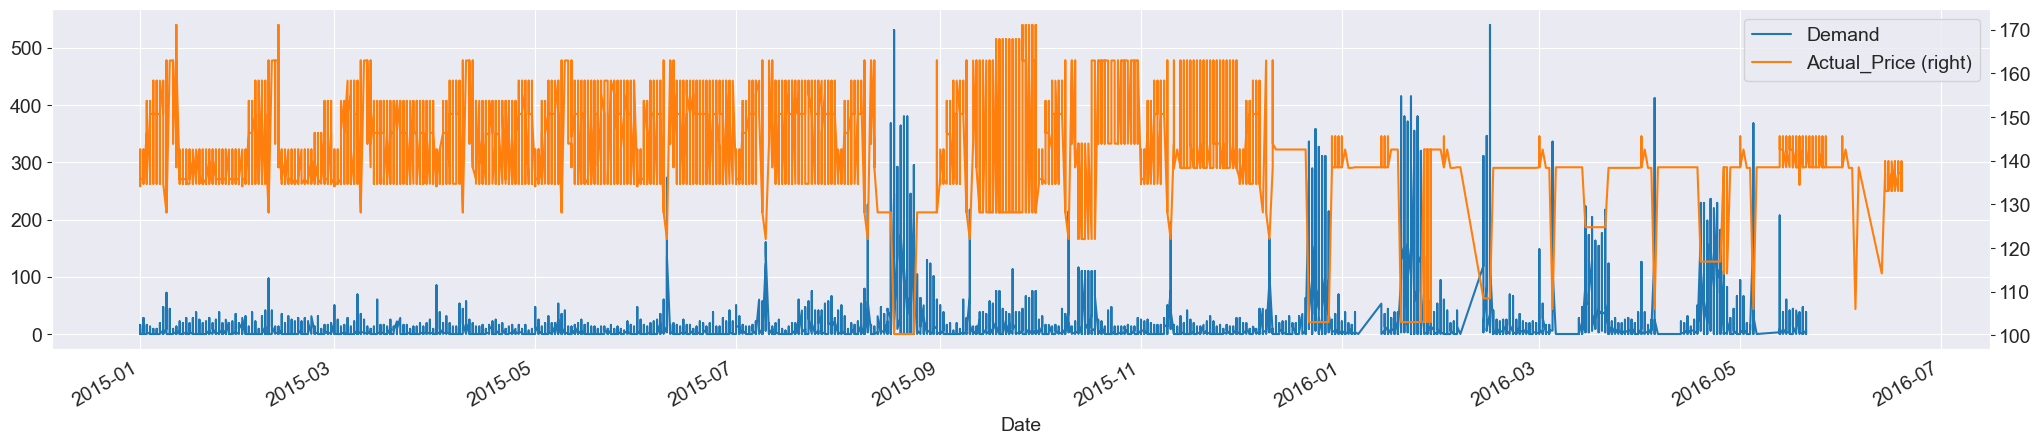

In [412]:
# Aggregate on Sku - All Stores level
sales_by_sku = train.groupby(['SKU_id','Store_id','Date']).agg({'Demand':'sum','Promo':'sum','Actual_Price':'mean'}).reset_index().set_index('Date')
sales_by_sku.loc[test_start_dt:,'Demand'] = np.NaN # fill test period Demand with Nan

sales_by_sku[sales_by_sku['SKU_id'] == 1][['Demand', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

sales_by_sku[sales_by_sku['SKU_id'] == 2][['Demand', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

In [413]:
sales_by_sku.head()

,SKU_id,Store_id,Demand,Promo,Actual_Price
Date,,,,,
2015-01-01,1,1,22.0,0.0,163.78
2015-01-02,1,1,160.0,0.0,146.92
2015-01-03,1,1,528.0,0.0,143.93
2015-01-04,1,1,75.0,0.0,133.33
2015-01-05,1,1,82.0,0.0,131.70


# ML for time series Forecasting

In [414]:
import holidays

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015-01-01', end='2016-12-31').to_pydatetime()

# feature generation
data = sales_by_sku.reset_index().copy(deep = True)

data["weekday"] = data.Date.dt.weekday
data["monthday"] = data.Date.dt.day
data['is_weekend'] = data.weekday.isin([5,6])*1
data['is_observable_holiday'] = data.Date.isin(holidays)*1
# data

data.head()

,Date,SKU_id,Store_id,Demand,Promo,Actual_Price,weekday,monthday,is_weekend,is_observable_holiday
0,2015-01-01,1,1,22.0,0.0,163.78,3,1,0,1
1,2015-01-02,1,1,160.0,0.0,146.92,4,2,0,0
2,2015-01-03,1,1,528.0,0.0,143.93,5,3,1,0
3,2015-01-04,1,1,75.0,0.0,133.33,6,4,1,0
4,2015-01-05,1,1,82.0,0.0,131.70,0,5,0,0


In [415]:
data.tail()

,Date,SKU_id,Store_id,Demand,Promo,Actual_Price,weekday,monthday,is_weekend,is_observable_holiday
85759,2016-06-15,2,110,NaN,0.0,133.06,2,15,0,0
85760,2016-06-16,2,110,NaN,0.0,133.06,3,16,0,0
85761,2016-06-17,2,110,NaN,0.0,133.06,4,17,0,0
85762,2016-06-18,2,110,NaN,0.0,133.06,5,18,1,0
85763,2016-06-19,2,110,NaN,0.0,133.06,6,19,1,0


### Lagged Features Generation

In [416]:
from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

def lagged_features(df
                    , target_var = 'demand'
                    , org_id_columns = ['product_rk', 'store_location_rk']
                    , all_id_columns =['product_rk', 'store_location_rk', 'period_start_dt']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = None
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_var - column name which is used to calculate lagged features
        org_id_columns - id columns, lagged featires is calculated within each id element independatnly
        all_id_columns - id columns + timestamp column
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    out_df = deepcopy(df)

    if filters is None:
      filters = {'':{''}}

    keys, values = zip(*filters.items())
    for bundle in product(*values):
              
      condition = ' & '.join([keys[i]+ filters[keys[i]][bundle[i]] for i in range(len(keys))])
      name =  '_'.join([bundle[i] for i in range(len(keys))])
      if len(condition) >0:
        _idx = df.eval(condition)
      else:
        _idx = df.index>=0
        
      if len(df[_idx].index)>0:
        for w in windows:
          lf_df = df[_idx].set_index(all_id_columns)[target_var].\
                    groupby(level=org_id_columns).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods))
          for l in lags:
            new_names = {x: "lag{0}_wdw{1}_{2}_{3}".
                          format(l, w, x, name) for x in lf_df.columns }

            out_df = pd.merge(out_df, lf_df.shift(l).reset_index().rename(columns = new_names),
                  how='left', on =all_id_columns )
            

    return out_df

In [417]:
from ipywidgets import IntProgress

from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_
    
# add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    results = groupby_day.sum(min_count=1)

    idx = pd.period_range(min_date, max_date)
    results = results.reindex(idx, fill_value=np.nan)

    results.index.rename(date_col, inplace=True)

    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation
    data_preag = data.groupby(group_col).agg(
        preagg_method)[target_cols].reset_index()

    ## fill missing dates
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
        fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                    axis=1).reset_index()

    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):

    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):

    lf_df = lf_df_filled.groupby(
        level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
    lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df


def generate_lagged_features(
        data: pd.DataFrame,
        target_cols: list = ['Demand'],
        id_cols: list = ['SKU_id', 'Store_id'],
        date_col: str = 'Date',
        lags: list = [7, 14, 21, 28],
        windows: list = ['7D', '14D', '28D', '56D'],
        preagg_methods: list = ['mean'],
        agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
        dynamic_filters: list = ['weekday', 'Promo'],
        ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}) -> pd.DataFrame:
    
    ''' 
    data - dataframe with default index
    target_cols - column names for lags calculation
    id_cols - key columns to identify unique values
    date_col - column with datetime format values
    lags - lag values(days)
    windows - windows(days/weeks/months/etc.),
        calculation is performed within time range length of window
    preagg_methods - applied methods before rolling to make
        every value unique for given id_cols
    agg_methods - method of aggregation('mean', 'median', percentile, etc.)
    dynamic_filters - column names to use as filter
    ewm_params - span values(days) for each dynamic_filter
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]

    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)

    for filter_col in dynamic_filters:
        group_col = [filter_col] + id_cols + [date_col]
        for lag in lags:
            for preagg in preagg_methods:
                data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                                    target_cols, preagg)

                ## add ewm features
                for alpha in ewm_params.get(filter_col, []):
                    ewm_filled = calc_ewm(data_preag_filled, group_col,
                                          date_col, alpha)
                    ewm = shift(ewm_filled, group_col, date_col, lag)
                    new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
                        format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df,
                                      ewm.rename(columns=new_names),
                                      how='left',
                                      on=group_col)
                
                ## add rolling features
                for w in windows:
                    for method in agg_methods:
                        rolling_filled = calc_rolling(data_preag_filled,
                                                      group_col, date_col,
                                                      method, w)

                        ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
                        rolling = shift(rolling_filled, group_col, date_col,
                                        lag)

                        method_name = method.__name__ if type(
                            method) != str else method

                        new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                                     format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                        out_df = pd.merge(out_df,
                                          rolling.rename(columns=new_names),
                                          how='left',
                                          on=group_col)
                        progress.value += 1

    return out_df

In [418]:
target_cols = ['Demand']
id_cols = ['SKU_id', 'Store_id']
date_col = 'Date'
built_in_funcs = [pd.Series.kurtosis, pd.Series.skew]

data['NoFilter'] = 1
# TODO: add median
data_lagged_features = generate_lagged_features(data 
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [22, 28, 35]
                    , windows = ['14D', '21D', '28D', '56D']
                    , preagg_methods = ['sum'] # ['mean', 'count']
                    , agg_methods = ['mean', percentile(10),  percentile(90)]
                    , dynamic_filters = ['Promo', 'NoFilter']
                    , ewm_params={'NoFilter': [14, 28], 'Promo': [14, 28]}
                    )

IntProgress(value=0, max=72)

In [419]:
data_lagged_features.to_csv('data_lagged_features.csv', sep='\t')

# number of columns
print(len(data_lagged_features.columns))
data_lagged_features.columns

95


Index(['Date', 'SKU_id', 'Store_id', 'Demand', 'Promo', 'Actual_Price',
       'weekday', 'monthday', 'is_weekend', 'is_observable_holiday',
       'NoFilter',
       'Demand_lag22d_alpha14_keySKU_id_Store_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag22d_alpha28_keySKU_id_Store_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag22d_w14D_keySKU_id_Store_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w14D_keySKU_id_Store_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag22d_w14D_keySKU_id_Store_id_preagsum_agpctl90_Promo_dynamic_rolling',
       'Demand_lag22d_w21D_keySKU_id_Store_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w21D_keySKU_id_Store_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag22d_w21D_keySKU_id_Store_id_preagsum_agpctl90_Promo_dynamic_rolling',
       'Demand_lag22d_w28D_keySKU_id_Store_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w28D_keySKU_id_Store_id_preagsum_agpctl10_Promo_dyna

## ML model definition

In [450]:
# put date in index
data_lagged_features.set_index('Date', inplace = True)
data_lagged_features.head()

KeyError: "None of ['Date'] are in the columns"

In [421]:
data_lagged_features.tail()

,SKU_id,Store_id,Demand,Promo,Actual_Price,weekday,monthday,is_weekend,is_observable_holiday,NoFilter,...,Demand_lag35d_w14D_keySKU_id_Store_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_Store_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_Store_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_Store_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_Store_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_Store_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_Store_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_Store_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_Store_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_Store_id_preagsum_agpctl90_NoFilter_dynamic_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-19,1,99,NaN,1.0,125.04,6,19,1,0,1,...,NaN,284.692308,NaN,NaN,585.600000,NaN,NaN,377.225000,NaN,NaN
2016-06-19,1,98,NaN,1.0,125.04,6,19,1,0,1,...,NaN,203.230769,NaN,NaN,420.500000,NaN,NaN,269.250000,NaN,NaN
2016-06-19,1,97,NaN,1.0,125.04,6,19,1,0,1,...,NaN,126.571429,NaN,NaN,126.571429,NaN,NaN,107.555556,NaN,NaN
2016-06-19,1,101,NaN,1.0,125.04,6,19,1,0,1,...,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN
2016-06-19,2,110,NaN,0.0,133.06,6,19,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [422]:
# train specific model for each SKU and Store
sku1_train = data_lagged_features[data_lagged_features['SKU_id'] == 1]
sku2_train = data_lagged_features[data_lagged_features['SKU_id'] == 2]

## ML Model Training

In [423]:
# try lightgbm as ml algorithm
import lightgbm as lgb
kwargs={'early_stopping_rounds':10,'verbose':2}

def plot_feature_importance(model, X , num = 20): 
  # , fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    # plt.figure(figsize=fig_size)
    # sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

In [452]:
# without CV
lgbm1 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')
lgbm1.fit(X = sku1_train.loc[:test_start_dt].drop(['SKU_id','Store_id','Demand'], axis=1), y = sku1_train.loc[:test_start_dt].Demand)

lgbm2 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')

lgbm2.fit(X = sku2_train.loc[:test_start_dt].drop(['SKU_id','Store_id','Demand'], axis=1), y = sku2_train.loc[:test_start_dt].Demand)

LGBMRegressor(feature_fraction=0.7, metric='mae', n_estimators=500,
              num_leaves=40, subsample=0.4)

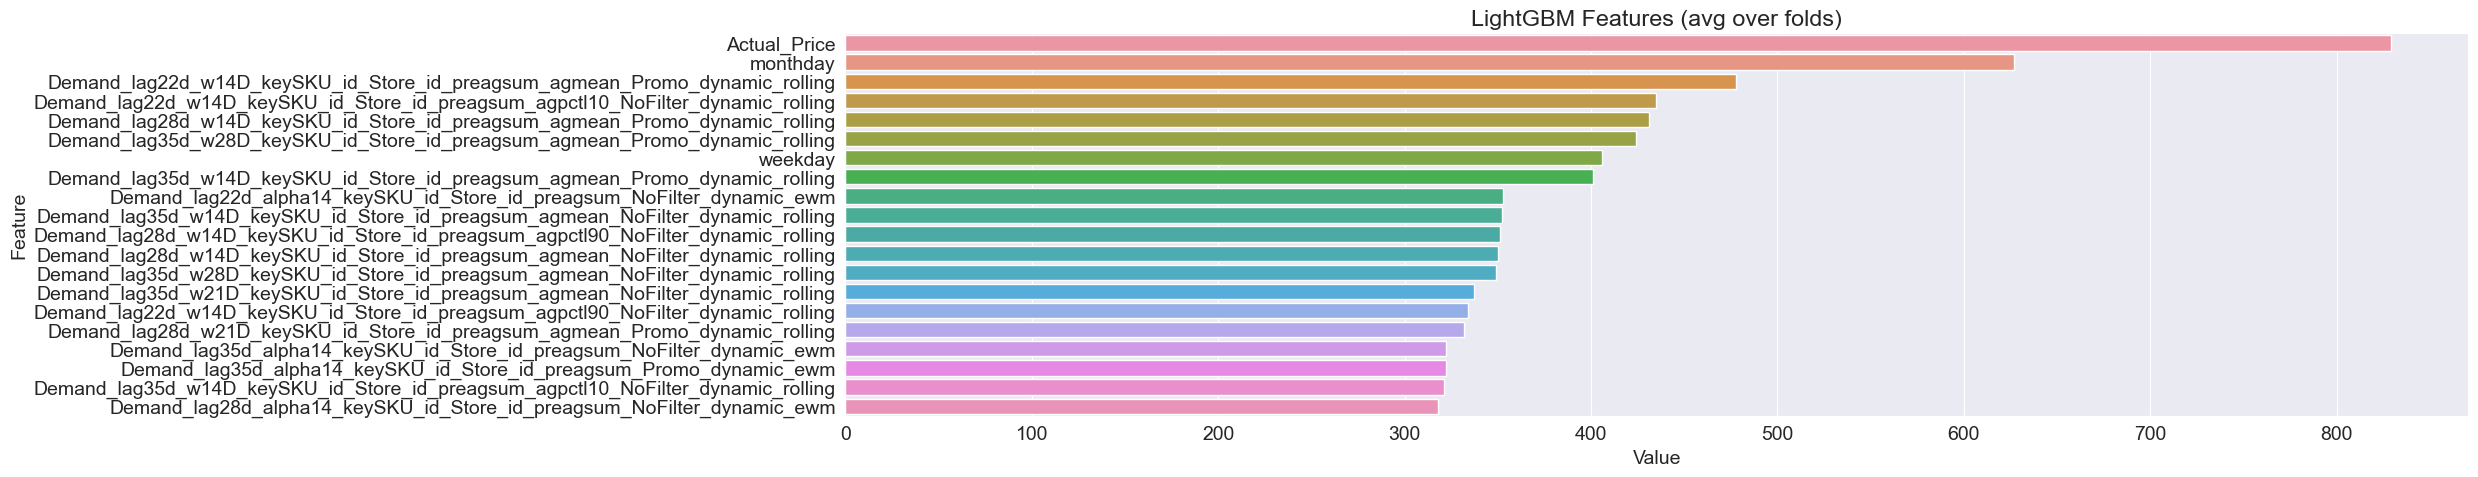

In [454]:
plot_feature_importance(lgbm1, sku1_train[sku1_train.columns[3:]], num = 20)

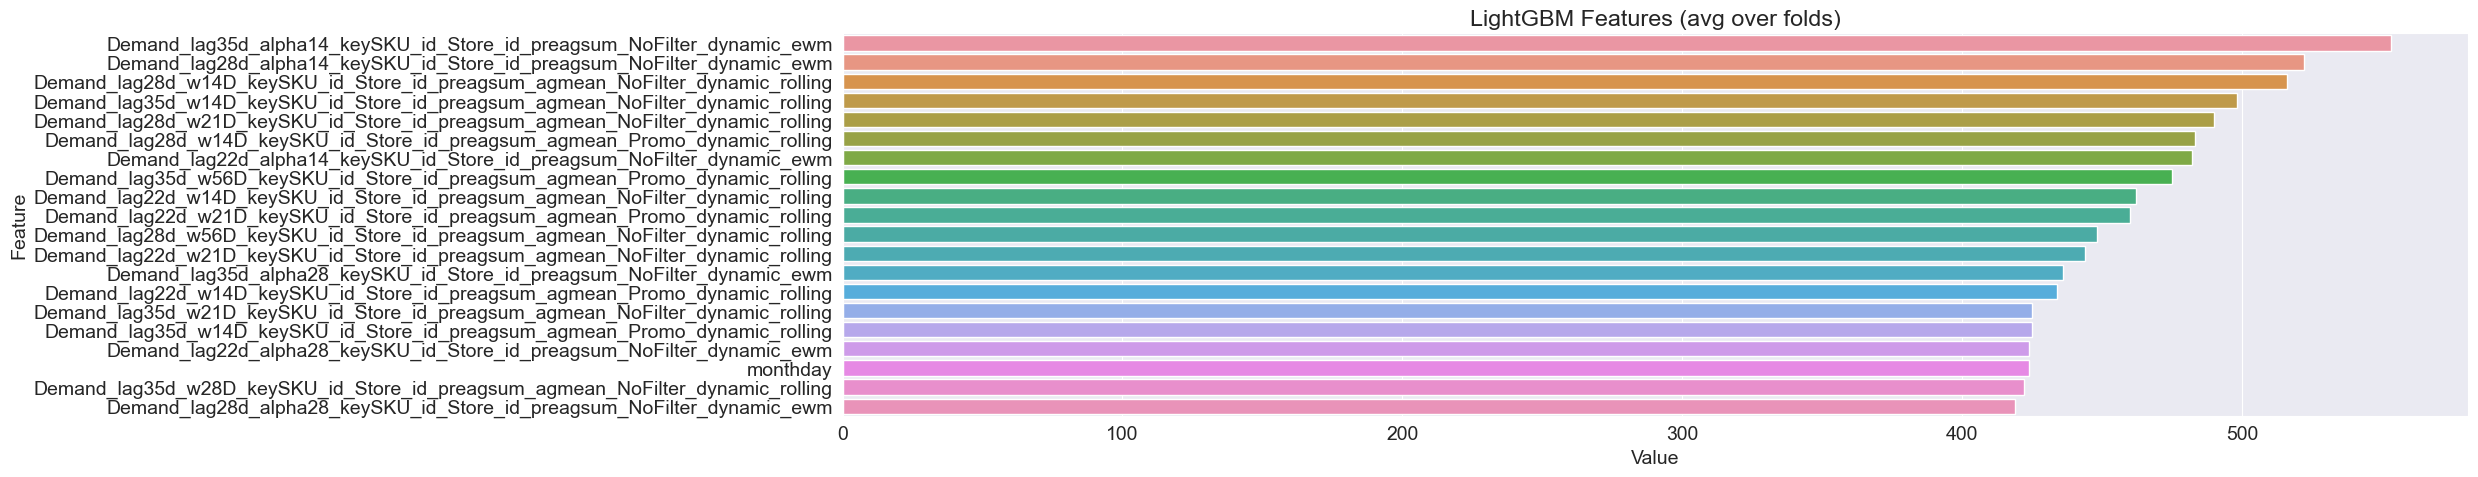

In [455]:
plot_feature_importance(lgbm2, sku2_train[sku2_train.columns[3:]], num = 20)

### Cross-validation for time series
 **Caution**: ml parameters tuning steps are omitted! Only tech approach is shown.

In [456]:
#  time series cross validation
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    # size of a fold
    fold_size = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(fold_size))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        train_share = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(fold_size*i)]
        y = y_train[:(fold_size*i)]
        print('Size of train and test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * train_share))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [458]:
# Train sets
X_train1 = sku1_train.loc[:test_start_dt].drop(['SKU_id','Store_id','Demand'], axis=1)
y_train1 = sku1_train.loc[:test_start_dt].Demand
X_train2 = sku2_train.loc[:test_start_dt].drop(['SKU_id','Store_id','Demand'], axis=1)
y_train2 = sku2_train.loc[:test_start_dt].Demand

In [459]:
# test sets
X_test1 = sku1_train.loc[test_start_dt:].drop(['SKU_id','Store_id','Demand'], axis=1)
X_test2 = sku2_train.loc[test_start_dt:].drop(['SKU_id','Store_id','Demand'], axis=1)

In [445]:
# WAPE realizaion for lgbm train
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [460]:
# run TS CV for the sku 1 (if needed)
performTimeSeriesCV(X_train1, y_train1, 17, lgbm1, wape, kwargs)

Size train set: (40861, 91)
Size of each fold: 2403

Splitting the first 2 chunks at 1/2
Size of train and test: (4806, 91)
[2]	valid_0's l1: 225.026
[4]	valid_0's l1: 218.174
[6]	valid_0's l1: 211.982
[8]	valid_0's l1: 208.817
[10]	valid_0's l1: 204.935
[12]	valid_0's l1: 204.676
[14]	valid_0's l1: 203.735
[16]	valid_0's l1: 203.978
[18]	valid_0's l1: 203.306
[20]	valid_0's l1: 203.119
[22]	valid_0's l1: 204.17
[24]	valid_0's l1: 203.897
[26]	valid_0's l1: 203.048
[28]	valid_0's l1: 203.69

Splitting the first 3 chunks at 2/3
Size of train and test: (7209, 91)
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[2]	valid_0's l1: 309.298
[4]	valid_0's l1: 285.567
[6]	valid_0's l1: 269.951
[8]	valid_0's l1: 257.983
[10]	valid_0's l1: 249.671
[12]	valid_0's l1: 242.362
[14]	valid_0's l1: 237.631
[16]	valid_0's l1: 233.635
[18]	valid_0's l1: 230.322
[20]	valid_0's l1: 228.913
[22]	valid_0's l1: 227.885
[24]	valid_0's 

48.78483886080561

In [461]:
# run TS CV for the sku 2 (if needed)
performTimeSeriesCV(X_train2, y_train2, 17, lgbm2, wape, kwargs)

Size train set: (40311, 91)
Size of each fold: 2371

Splitting the first 2 chunks at 1/2
Size of train and test: (4742, 91)
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[2]	valid_0's l1: 3.48266
[4]	valid_0's l1: 3.40939
[6]	valid_0's l1: 3.35368
[8]	valid_0's l1: 3.31874
[10]	valid_0's l1: 3.29234
[12]	valid_0's l1: 3.28258
[14]	valid_0's l1: 3.2813
[16]	valid_0's l1: 3.26293
[18]	valid_0's l1: 3.28902
[20]	valid_0's l1: 3.26583
[22]	valid_0's l1: 3.29691
[24]	valid_0's l1: 3.32407
[26]	valid_0's l1: 3.34455

Splitting the first 3 chunks at 2/3
Size of train and test: (7113, 91)
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[2]	valid_0's l1: 3.12142
[4]	valid_0's l1: 3.0053
[6]	valid_0's l1: 2.93063
[8]	valid_0's l1: 2.88029
[10]	valid_0's l1: 2.83911
[12]	valid_0's l1: 2.80866
[14]	valid_0's l1: 2.79286
[16]	valid_0's l1: 2.7811


79.06235846278865

## Forecast Generation with ML

<AxesSubplot: xlabel='Date'>

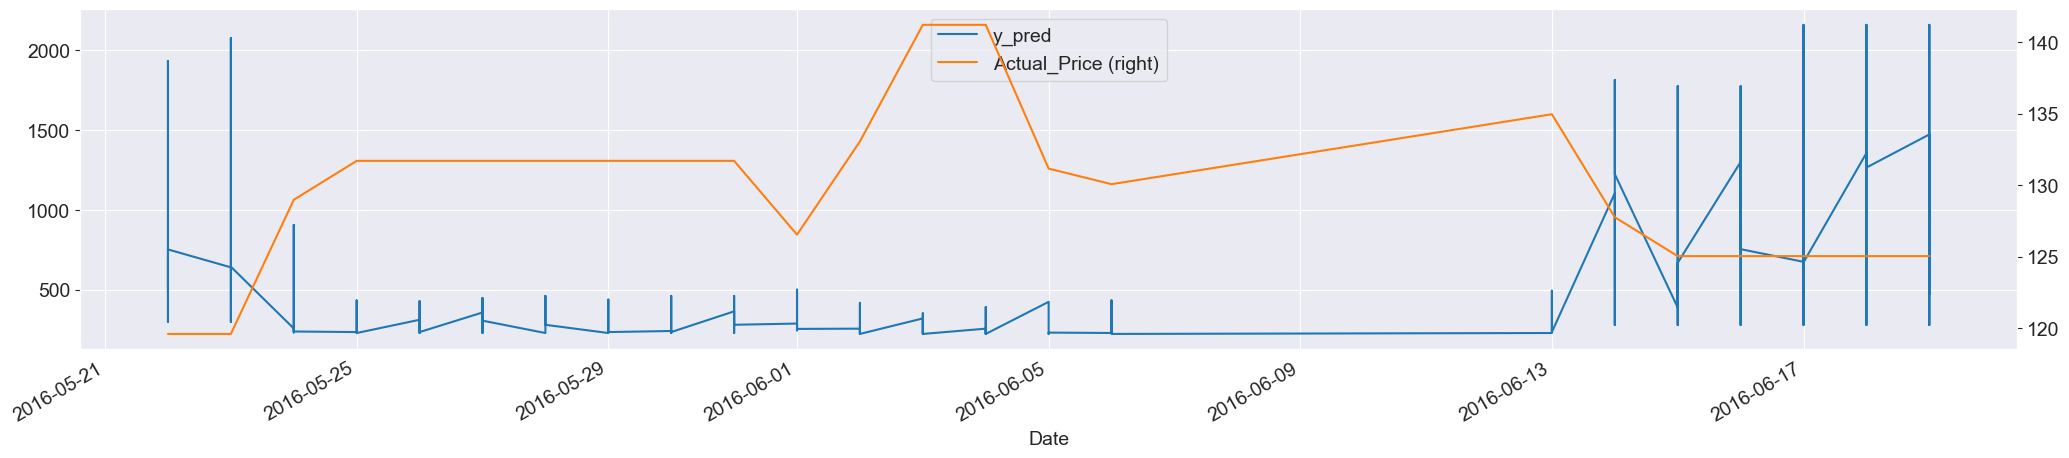

In [462]:
# forecast for sku 1
X_test1['y_pred'] = lgbm1.predict(X_test1)
X_test1[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

<AxesSubplot: xlabel='Date'>

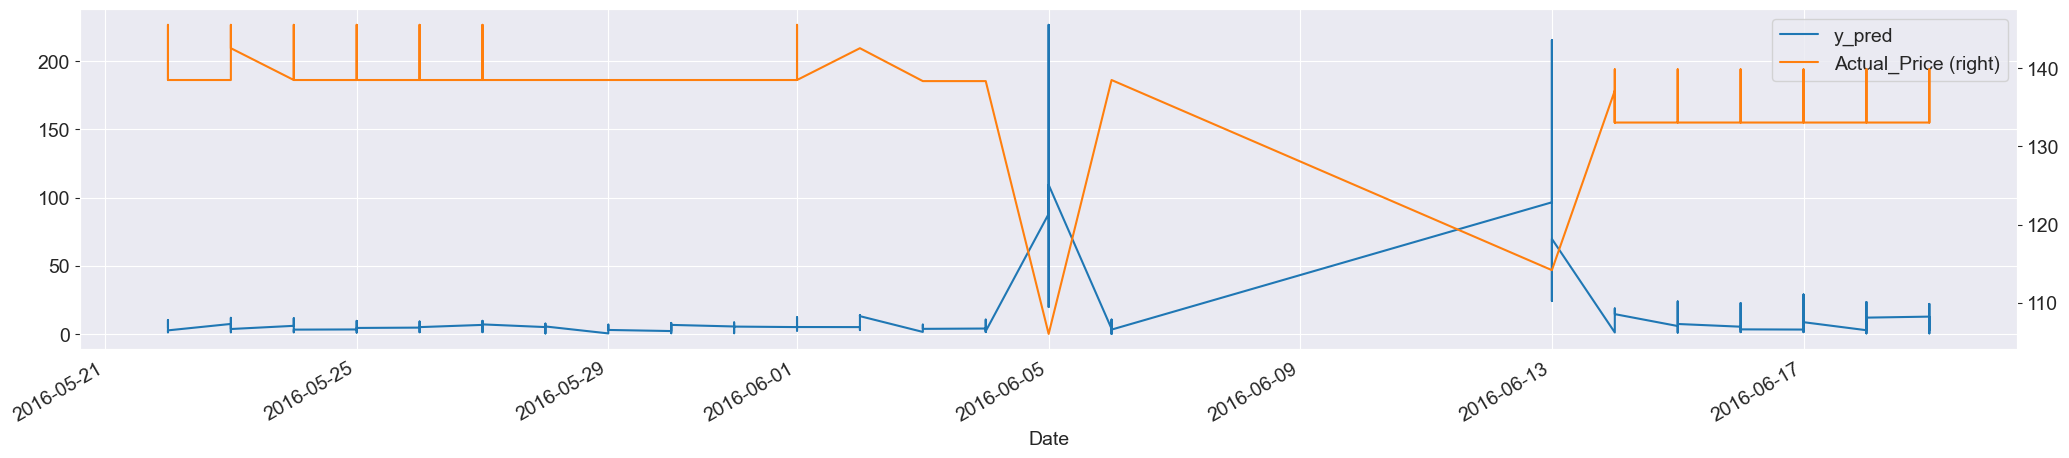

In [449]:
# forecast for sku 2
X_test2['y_pred'] = lgbm2.predict(X_test2)
X_test2[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

In [267]:
X_test2.head()

,Promo,Store_count,Actual_Price,weekday,monthday,is_weekend,is_observable_holiday,NoFilter,Demand_lag22d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm,Demand_lag22d_alpha28_keySKU_id_preagsum_Promo_dynamic_ewm,...,Demand_lag35d_w21D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,y_pred
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-22,99.0,99,116.890000,4,22,0,0,1,NaN,NaN,...,2882.642857,NaN,NaN,2088.809524,NaN,NaN,2690.047619,NaN,NaN,5962.918143
2016-04-23,99.0,99,116.890000,5,23,1,0,1,NaN,NaN,...,3215.857143,NaN,NaN,2303.809524,NaN,NaN,2539.523810,NaN,NaN,5954.365993
2016-04-24,99.0,99,116.890000,6,24,1,0,1,NaN,NaN,...,3568.142857,NaN,NaN,2526.523810,NaN,NaN,2440.738095,NaN,NaN,6095.453966
2016-04-25,99.0,99,116.890000,0,25,0,0,1,NaN,NaN,...,3926.714286,NaN,NaN,2754.904762,NaN,NaN,2358.142857,NaN,NaN,6097.479306
2016-04-26,21.0,99,133.339091,1,26,0,0,1,NaN,NaN,...,3917.071429,NaN,NaN,2759.285714,NaN,NaN,2349.380952,NaN,NaN,2273.413374


**Note**: forecast highly depends on key drivers

<AxesSubplot: title={'center': 'WAPE=0.18401388474247032'}, xlabel='Date'>

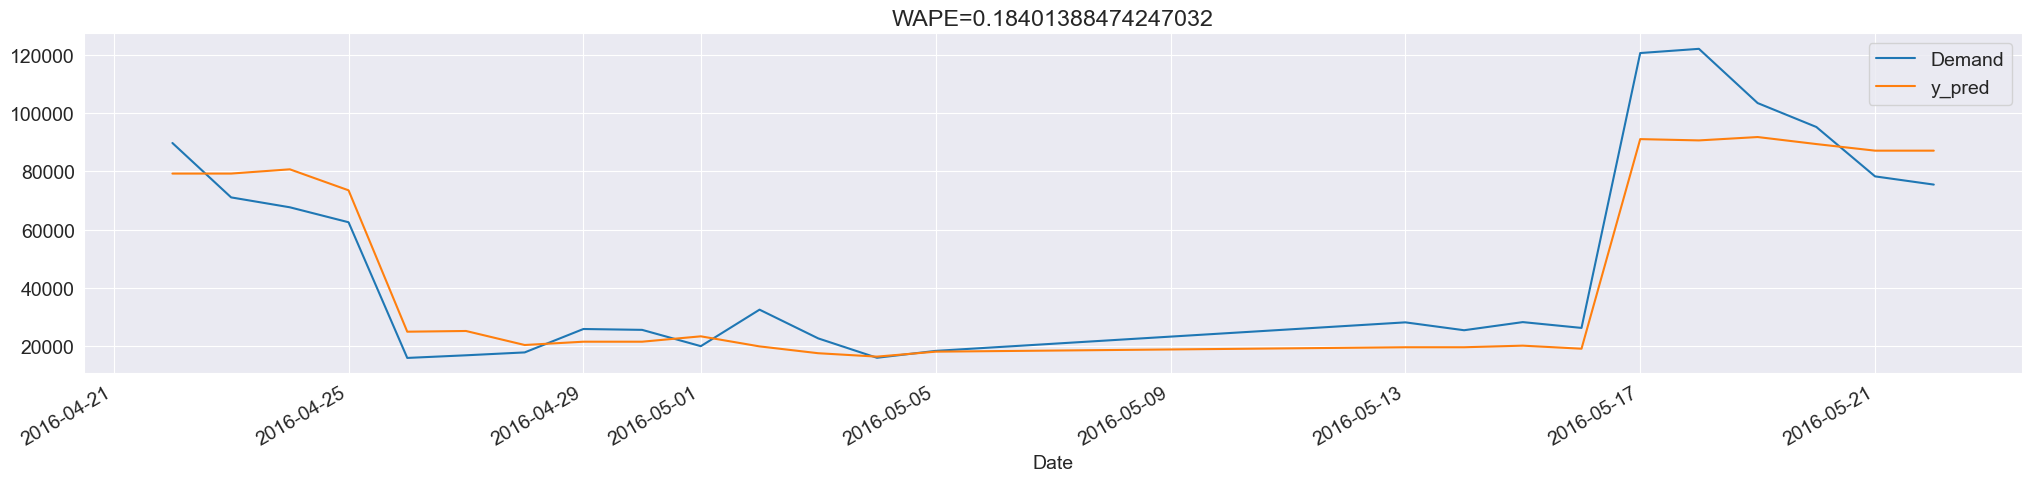

In [266]:
y_true = test_y.groupby(['SKU_id','Date']).agg({'Demand':'sum'}).reset_index().set_index('Date')

# WAPE for sku 1
qlt , _ = qualityWAPE(y_true[y_true['SKU_id']==1]['Demand'], X_test1['y_pred'])

# Draw forecast and actuals
X_test1.merge(y_true[y_true['SKU_id']==1], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].plot(title = 'WAPE='+str(qlt))


<AxesSubplot: title={'center': 'WAPE=0.282126937815561'}, xlabel='Date'>

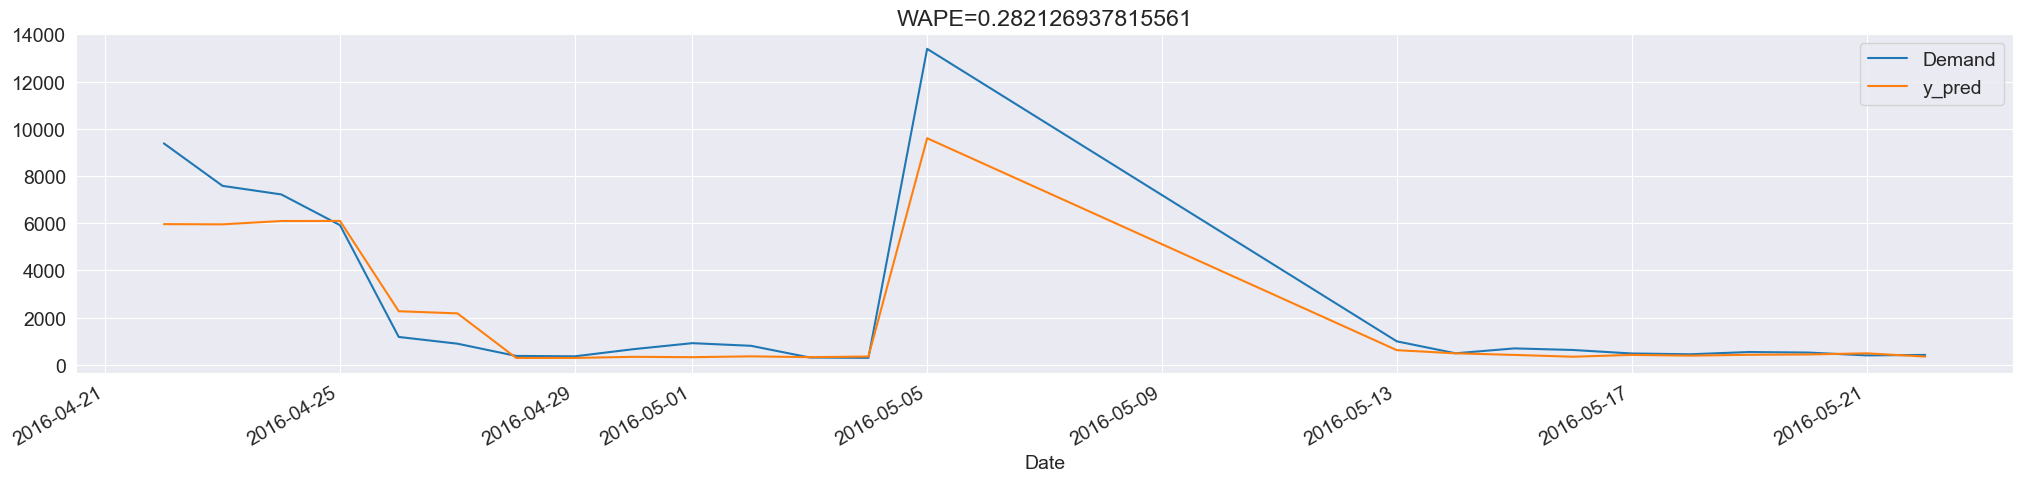

In [229]:
# WAPE for sku 2
qlt , _ = qualityWAPE(y_true[y_true['SKU_id']==2]['Demand'], X_test2['y_pred'])

# Draw forecast and actuals
X_test2.merge(y_true[y_true['SKU_id']==2], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].plot(title = 'WAPE='+str(qlt))


**Materials**
* Cross-validation for time series https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
* M - competition
  - M5: https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163414
  - M4: https://www.sciencedirect.com/science/article/pii/S0169207019301128